# Polynomial Fit Method

This notebook is to explore the polynomial fit-based definition of the mean profile from the Castro group. First, let's compare to the box used in the deep_dive notebook. Then if things go well we can explore the globe

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [2]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Section

In [4]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [6]:
section = ds_p.where((ds_p.LATITUDE < -25) & (ds_p.LATITUDE > -35),drop=True).where((ds_p.LONGITUDE < -138) & (ds_p.LONGITUDE > -140),drop=True).sortby('LATITUDE')

In [7]:
section = section.sortby('N_PROF')

#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_p = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [8]:
section_p = section_p.rename({'PRES_INTERPOLATED':'PRESSURE','N_PROF':'PROFILE','LATITUDE':'LAT','LONGITUDE':'LON'})

In [11]:
section_p['SIG1'] = (('PROFILE','PRESSURE'), gsw.density.sigma1(section_p.SA, section_p.CT).values)

In [12]:
nprof = section_p.dims["PROFILE"]
section_p = section_p.assign_coords(NUM=("PROFILE", np.arange(nprof)))

/home/amf2288/miniconda3/envs/Argo_Feb_25/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## Polynomial fit method

In [14]:
section_p

<xarray.Dataset>
Dimensions:          (PROFILE: 409, PRESSURE: 1001)
Coordinates:
  * PRESSURE         (PRESSURE) int64 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * PROFILE          (PROFILE) int64 1983300 1983280 1984183 ... 1264653 1263963
    TIME             (PROFILE) datetime64[ns] 2018-03-28T01:11:23 ... 2017-09...
    LAT              (PROFILE) float64 -34.9 -34.88 -34.81 ... -25.3 -25.1 -25.1
    LON              (PROFILE) float64 -138.6 -138.7 -138.5 ... -139.6 -139.4
    NUM              (PROFILE) int64 0 1 2 3 4 5 6 ... 403 404 405 406 407 408
Data variables:
    CT               (PROFILE, PRESSURE) float64 nan 20.88 20.89 ... 1.966 nan
    CYCLE_NUMBER     (PROFILE, PRESSURE) float64 nan 95.0 95.0 ... 76.0 76.0 nan
    PLATFORM_NUMBER  (PROFILE, PRESSURE) float64 nan 5.902e+06 ... 5.902e+06 nan
    PRES             (PROFILE, PRESSURE) float32 nan 2.0 4.0 ... 1.998e+03 nan
    PSAL             (PROFILE, PRESSURE) float32 nan 34.59 34.59 ... 34.63 nan
    SA               (PROFILE, PRESSURE) float64 nan 34.75 34.75 ... 34.8 nan
    SIG0             (PROFILE, PRESSURE) float64 nan 24.22 24.22 ... 27.69 nan
    TEMP             (PROFILE, PRESSURE) float32 nan 20.88 20.88 ... 2.104 nan
    sample_rate      (PROFILE, PRESSURE) float32 nan 0.9 1.0 ... 2.0 2.0 nan
    SPICE            (PROFILE, PRESSURE) float64 nan 3.434 3.436 ... -0.1042 nan
    SIG1             (PROFILE, PRESSURE) float64 nan 28.48 28.48 ... 32.34 nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [34]:
def moving_average(arr, window):
    """
    Compute moving average of array with given window size.
    Edges are trimmed to avoid edge effects.
    """
    if len(arr) < window:
        return arr
    
    # Use convolution to compute moving average
    kernel = np.ones(window) / window
    smoothed = np.convolve(arr, kernel, mode='valid')
    return smoothed

In [35]:
# Initialize output arrays for smoothed profiles
nprof = section_p.dims['PROFILE']
npres = section_p.dims['PRESSURE']

CT_m = np.full((nprof, npres), np.nan)
SA_m = np.full((nprof, npres), np.nan)
SPICE_m = np.full((nprof, npres), np.nan)

In [36]:
# Loop through each profile and apply polynomial fitting + moving average smoothing
for i in range(nprof):
    # Find valid (finite) data points for this profile
    jj = np.where(np.isfinite(section_p['CT'].values[:, i] + section_p['SIG1'].values[:, i]))[0]
    
    if len(jj) < 5:  # Skip if too few valid points
        continue
    
    # Get density and variables for valid points
    sig0_valid = section_p['SIG1'].values[jj, i]
    ct_valid = section_p['CT'].values[jj, i]
    sa_valid = section_p['SA'].values[jj, i]
    spice_valid = section_p['SPICE'].values[jj, i]
    
    # Fit 4th-degree polynomials to (density, variable) pairs
    p_ct = np.polyfit(sig0_valid, ct_valid, 4)
    pp_ct = np.poly1d(p_ct)
    
    p_sa = np.polyfit(sig0_valid, sa_valid, 4)
    pp_sa = np.poly1d(p_sa)
    
    p_spice = np.polyfit(sig0_valid, spice_valid, 4)
    pp_spice = np.poly1d(p_spice)
    
    # Create smoothed density grid by sorting and applying moving average
    sort_idx = np.argsort(sig0_valid)
    sig0_sorted = sig0_valid[sort_idx]
    sig0_smooth = moving_average(sig0_sorted, 5)
    
    # Evaluate polynomial at smoothed density grid to get smoothed values
    ct_smooth = pp_ct(sig0_smooth)
    sa_smooth = pp_sa(sig0_smooth)
    spice_smooth = pp_spice(sig0_smooth)
    
    # Interpolate smoothed values back to ORIGINAL density values
    # This ensures we only have values where we started with data
    try:
        f_ct = interpolate.PchipInterpolator(sig0_smooth, ct_smooth, extrapolate=False)
        f_sa = interpolate.PchipInterpolator(sig0_smooth, sa_smooth, extrapolate=False)
        f_spice = interpolate.PchipInterpolator(sig0_smooth, spice_smooth, extrapolate=False)
        
        # Interpolate back to original (unsorted) density points
        # Only store at original pressure indices (jj)
        CT_m[i, jj] = f_ct(sig0_valid)
        SA_m[i, jj] = f_sa(sig0_valid)
        SPICE_m[i, jj] = f_spice(sig0_valid)
    except (ValueError, RuntimeError):
        # Skip profiles where interpolation fails
        pass
    
    if (i + 1) % 50 == 0:
        print(f"Completed {i + 1}/{nprof} profiles")

Completed 50/409 profiles
Completed 100/409 profiles
Completed 150/409 profiles
Completed 200/409 profiles
Completed 250/409 profiles
Completed 300/409 profiles


/tmp/ipykernel_3737869/2844136372.py:16: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:19: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:22: RankWarning: Polyfit may be poorly conditioned
  p_spice = np.polyfit(sig0_valid, spice_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:16: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:19: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:22: RankWarning: Polyfit may be poorly conditioned
  p_spice = np.polyfit(sig0_valid, spice_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:16: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:19: RankWarning: Pol

Completed 350/409 profiles
Completed 400/409 profiles


/tmp/ipykernel_3737869/2844136372.py:16: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:19: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:22: RankWarning: Polyfit may be poorly conditioned
  p_spice = np.polyfit(sig0_valid, spice_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:16: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:19: RankWarning: Polyfit may be poorly conditioned
  p_sa = np.polyfit(sig0_valid, sa_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:22: RankWarning: Polyfit may be poorly conditioned
  p_spice = np.polyfit(sig0_valid, spice_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:16: RankWarning: Polyfit may be poorly conditioned
  p_ct = np.polyfit(sig0_valid, ct_valid, 4)
/tmp/ipykernel_3737869/2844136372.py:19: RankWarning: Pol

In [37]:
# Add the smoothed variables to section_p as new data variables
section_p['CT_m'] = (('PROFILE', 'PRESSURE'), CT_m)
section_p['SA_m'] = (('PROFILE', 'PRESSURE'), SA_m)
section_p['SPICE_m'] = (('PROFILE', 'PRESSURE'), SPICE_m)

print("Successfully added CT_m, SA_m, and SPICE_m to section_p")

Successfully added CT_m, SA_m, and SPICE_m to section_p


In [38]:
# Verify the results
section_p

<xarray.Dataset>
Dimensions:          (PROFILE: 409, PRESSURE: 1001)
Coordinates:
  * PRESSURE         (PRESSURE) int64 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * PROFILE          (PROFILE) int64 1983300 1983280 1984183 ... 1264653 1263963
    TIME             (PROFILE) datetime64[ns] 2018-03-28T01:11:23 ... 2017-09...
    LAT              (PROFILE) float64 -34.9 -34.88 -34.81 ... -25.3 -25.1 -25.1
    LON              (PROFILE) float64 -138.6 -138.7 -138.5 ... -139.6 -139.4
    NUM              (PROFILE) int64 0 1 2 3 4 5 6 ... 403 404 405 406 407 408
Data variables: (12/14)
    CT               (PROFILE, PRESSURE) float64 nan 20.88 20.89 ... 1.966 nan
    CYCLE_NUMBER     (PROFILE, PRESSURE) float64 nan 95.0 95.0 ... 76.0 76.0 nan
    PLATFORM_NUMBER  (PROFILE, PRESSURE) float64 nan 5.902e+06 ... 5.902e+06 nan
    PRES             (PROFILE, PRESSURE) float32 nan 2.0 4.0 ... 1.998e+03 nan
    PSAL             (PROFILE, PRESSURE) float32 nan 34.59 34.59 ... 34.63 nan
    SA               (PROFILE, PRESSURE) float64 nan 34.75 34.75 ... 34.8 nan
    ...               ...
    sample_rate      (PROFILE, PRESSURE) float32 nan 0.9 1.0 ... 2.0 2.0 nan
    SPICE            (PROFILE, PRESSURE) float64 nan 3.434 3.436 ... -0.1042 nan
    SIG1             (PROFILE, PRESSURE) float64 nan 28.48 28.48 ... 32.34 nan
    CT_m             (PROFILE, PRESSURE) float64 nan nan nan nan ... nan nan nan
    SA_m             (PROFILE, PRESSURE) float64 nan nan nan nan ... nan nan nan
    SPICE_m          (PROFILE, PRESSURE) float64 nan nan nan nan ... nan nan nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

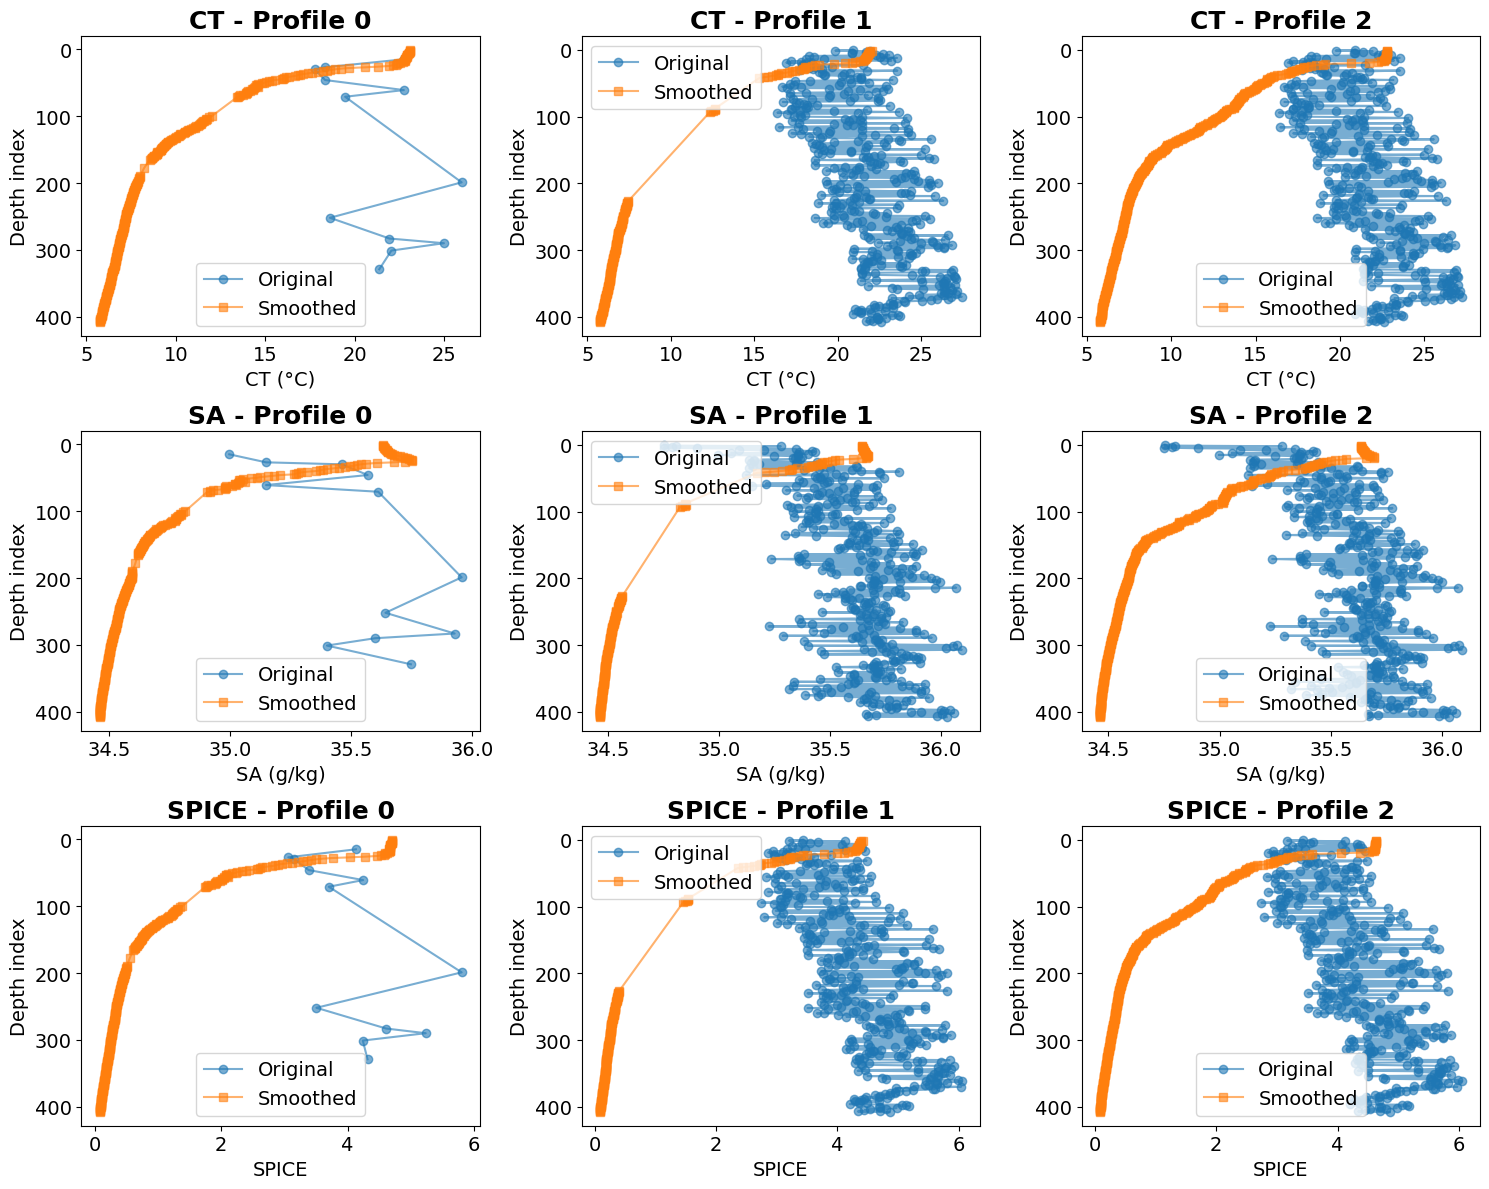

In [ ]:
# Quick visualization with twin y-axes: compare original vs smoothed for first few profiles
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for prof_idx in range(3):
    # CT
    ct_orig = section_p['CT'].values[:, prof_idx]
    ct_smooth = section_p['CT_m'].values[:, prof_idx]
    
    idx_orig = np.where(~np.isnan(ct_orig))[0]
    idx_smooth = np.where(~np.isnan(ct_smooth))[0]
    
    ax1 = axes[0, prof_idx]
    ax1.plot(ct_orig[idx_orig], idx_orig, 'o-', label='Original', alpha=0.8, color='blue', linewidth=2)
    ax1.set_ylabel('Depth index (Original)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel('CT (°C)')
    ax1.set_title(f'CT - Profile {prof_idx}')
    ax1.invert_yaxis()
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(ct_smooth[idx_smooth], idx_smooth, 's-', label='Smoothed', alpha=0.8, color='red', linewidth=2)
    ax1_twin.set_ylabel('Depth index (Smoothed)', color='red')
    ax1_twin.tick_params(axis='y', labelcolor='red')
    ax1_twin.invert_yaxis()
    
    # SA
    sa_orig = section_p['SA'].values[:, prof_idx]
    sa_smooth = section_p['SA_m'].values[:, prof_idx]
    
    idx_sa_orig = np.where(~np.isnan(sa_orig))[0]
    idx_sa_smooth = np.where(~np.isnan(sa_smooth))[0]
    
    ax2 = axes[1, prof_idx]
    ax2.plot(sa_orig[idx_sa_orig], idx_sa_orig, 'o-', label='Original', alpha=0.8, color='blue', linewidth=2)
    ax2.set_ylabel('Depth index (Original)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_xlabel('SA (g/kg)')
    ax2.set_title(f'SA - Profile {prof_idx}')
    ax2.invert_yaxis()
    
    ax2_twin = ax2.twinx()
    ax2_twin.plot(sa_smooth[idx_sa_smooth], idx_sa_smooth, 's-', label='Smoothed', alpha=0.8, color='red', linewidth=2)
    ax2_twin.set_ylabel('Depth index (Smoothed)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')
    ax2_twin.invert_yaxis()
    
    # SPICE
    spice_orig = section_p['SPICE'].values[:, prof_idx]
    spice_smooth = section_p['SPICE_m'].values[:, prof_idx]
    
    idx_spice_orig = np.where(~np.isnan(spice_orig))[0]
    idx_spice_smooth = np.where(~np.isnan(spice_smooth))[0]
    
    ax3 = axes[2, prof_idx]
    ax3.plot(spice_orig[idx_spice_orig], idx_spice_orig, 'o-', label='Original', alpha=0.8, color='blue', linewidth=2)
    ax3.set_ylabel('Depth index (Original)', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax3.set_xlabel('SPICE')
    ax3.set_title(f'SPICE - Profile {prof_idx}')
    ax3.invert_yaxis()
    
    ax3_twin = ax3.twinx()
    ax3_twin.plot(spice_smooth[idx_spice_smooth], idx_spice_smooth, 's-', label='Smoothed', alpha=0.8, color='red', linewidth=2)
    ax3_twin.set_ylabel('Depth index (Smoothed)', color='red')
    ax3_twin.tick_params(axis='y', labelcolor='red')
    ax3_twin.invert_yaxis()

plt.tight_layout()
plt.show()

In [40]:
# Diagnostics: check data coverage for first profile
prof_idx = 0

ct_orig = section_p['CT'].values[:, prof_idx]
ct_smooth = section_p['CT_m'].values[:, prof_idx]

orig_valid = ~np.isnan(ct_orig)
smooth_valid = ~np.isnan(ct_smooth)

print(f"Profile {prof_idx}:")
print(f"  Original data points: {np.sum(orig_valid)} / {len(ct_orig)}")
print(f"  Smoothed data points: {np.sum(smooth_valid)} / {len(ct_smooth)}")
print(f"  Original depth range: {np.where(orig_valid)[0][[0, -1]]}")
print(f"  Smoothed depth range: {np.where(smooth_valid)[0][[0, -1]]}")
print(f"\nFirst few original CT values: {ct_orig[orig_valid][:10]}")
print(f"First few smoothed CT values: {ct_smooth[smooth_valid][:10]}")

Profile 0:
  Original data points: 12 / 409
  Smoothed data points: 352 / 409
  Original depth range: [ 15 329]
  Smoothed depth range: [  1 408]

First few original CT values: [22.7480078  18.31260285 17.75921412 18.3453614  22.74774656 19.46546261
 25.97907583 18.61827308 21.94533806 24.98755476]
First few smoothed CT values: [23.08970628 23.08648373 23.08317593 23.07736826 23.05813404 23.03597401
 22.9798159  22.9420862  22.90591306 22.90231337]
